In [30]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

print("Done.")


[nltk_data] Downloading package punkt to /Users/kyungmin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kyungmin/nltk_data...


Done.


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Eng and Korean txt Parser

## Normal

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import re
from tqdm import tqdm
import nltk
import kss
from nltk.tokenize import sent_tokenize


# --- 0. 설정 및 파일 경로 ---
ENG_FILE_PATH = "eng_testp1.txt"
KOR_FILE_PATH = "kor_testp1.txt"
OUTPUT_FILE = "day1_aligned_data.npz"
EMBEDDING_DIM = 768
LABSE = "setu4993/LaBSE"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_sentences(sent_list, path):
    with open(path, "w", encoding="utf-8") as f:
        for s in sent_list:
            f.write(s.strip() + "\n")

def preprocess_text(text):
    text = re.sub(r'\n{2,}', '<PARA>', text)
    text = text.replace("\n", " ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("<PARA>", "\n\n")
    return text
# -----------------------------------------------------
# 1. 텍스트 로딩
# -----------------------------------------------------
def load_and_segment_text(file_path):
    """파일을 읽고 텍스트를 그대로 반환 (문장 분리는 아래에서 수행)."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text
    except FileNotFoundError:
        print(f"오류: 파일 없음 → {file_path}")
        return "" 


# -----------------------------------------------------
# 2. 문장 분리
# -----------------------------------------------------


def split_paragraphs(raw_text):
    # 문단 구분 (\n\n 이상)
    raw_paragraphs = re.split(r'\n\s*\n+', raw_text)

    # 문단 내부 줄바꿈은 공백으로 merge
    paragraphs = [
        re.sub(r'\n+', ' ', p).strip()
        for p in raw_paragraphs if p.strip()
    ]
    return paragraphs


def split_by_punctuation(text):
    # 문장부호 기반 분리
    parts = re.split(r'(?<=[.!?])\s+(?=[A-Za-z0-9“"‘\'가-힣])', text)
    return parts

def split_sentences(text):

    # 1) Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    sentences = []

    # 2) 먼저 따옴표 블록 분리
    quote_blocks = re.split(r'(“[^”]+”|"[^"]+")', text)

    for block in quote_blocks:
        if not block.strip():
            continue

        # 3) block이 따옴표로 둘러싸여 있으면 그대로 문장 후보에 넣고 내부 처리
        if (block.startswith("“") and block.endswith("”")) or \
           (block.startswith('"') and block.endswith('"')):
            sentences.extend(split_by_punctuation(block))
            continue

        # 4) 괄호 블록 분리
        paren_blocks = re.split(r'(\([^()]+\)[.!?;,]?)', block)

        for pblock in paren_blocks:
            if not pblock.strip():
                continue

            if pblock.startswith("(") and pblock.endswith(")"):
                sentences.extend(split_by_punctuation(pblock))
            else:
                sentences.extend(split_by_punctuation(pblock))

    return [s.strip() for s in sentences if s.strip()]


def split_quote_block_into_sentences(block):
    """
    인용부 안에서 ! ? 기준 분할하되,
    '!”', '?”', '."' 같이 닫힘 따옴표와 붙어있는 문장부호는 분리하지 않는다.
    """

    text = block.strip()

    # 1) 보호 패턴 치환
    protect_map = {
        '!”': '<EXCL_QUOTE>',
        '?”': '<Q_QUOTE>',
        '."': '<DOT_QUOTE>',
        '.”': '<DOT_QUOTE2>',
    }
    for k, v in protect_map.items():
        text = text.replace(k, v)

    # 2) 문장부호 기반 분리
    # 단, 치환된 패턴은 분리되지 않음
    tokens = re.split(r'([!?])', text)

    sentences = []
    curr = ""

    for t in tokens:
        if t in ['!', '?']:   # 문장 끝
            curr += t
            sentences.append(curr.strip())
            curr = ""
        else:
            curr += t

    if curr.strip():
        sentences.append(curr.strip())

    # 3) 패턴 복원
    result = []
    for s in sentences:
        for k, v in protect_map.items():
            s = s.replace(v, k)
        result.append(s)

    return result



def build_edu(sentences):
    """
    split_sentences 결과(문장 배열) → EDU 배열로 바꾸는 최종 규칙 함수
    (디버깅 출력 강화 버전)
    """
    edu_list = []
    N = len(sentences)
    i = 0

    print("\n===== BUILD_EDU DEBUG START =====")
    print(f"총 문장 수: {N}")
    print("----------------------------------")

    while i < N:
        sent = sentences[i].strip()
        print(f"\n▶ [INDEX {i}] 현재 문장: {sent}")

        # -----------------------
        # A. 인용부로 시작하는 경우
        # -----------------------
        if sent.startswith("“") or sent.startswith("\""):
            print(f"  → 인용부 시작 감지: {sent}")

            quote_block = [sent]
            i += 1
            print(f"  → 첫 인용문 저장: {quote_block}")

            # -----------------------
            # 1) 단문 인용부 처리
            # -----------------------
            if quote_block[0].rstrip().endswith("”") or quote_block[0].rstrip().endswith("\""):
                print("  → 단문 인용부 판정됨")

                if i < N:
                    nxt = sentences[i].strip()
                    print(f"    다음 문장 확인: {nxt}")

                    if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
                        print("    → 괄호문장 아님 → 단문 인용부 뒤에 문장 1개 자동 포함")
                        quote_block.append(nxt)
                        i += 1
                    else:
                        print("    → 괄호문장이라 자동 포함 스킵")

                print(f"  → 단문 인용부 EDU 확정: {quote_block}")
                edu_list.append(" ".join(quote_block))
                continue

            # -----------------------
            # 2) 장문 인용부 처리
            # -----------------------
            print("  → 장문 인용부 처리 시작")

            while i < N and not (
                sentences[i].strip().endswith("”") or sentences[i].strip().endswith("\"")
            ):
                print(f"    → 인용부 계속 추가: {sentences[i].strip()}")
                quote_block.append(sentences[i].strip())
                i += 1

            # 닫힘 인용부 포함
            if i < N:
                print(f"    → 닫힘 인용부 추가: {sentences[i].strip()}")
                quote_block.append(sentences[i].strip())
                i += 1

            print(f"  → 장문 인용부 전체 블록: {quote_block}")

            # -----------------------
            # Step 1: 3문장 단위 EDU 그룹화
            # -----------------------
            edu_groups = []
            for k in range(0, len(quote_block), 3):
                group = quote_block[k:k+3]
                print(f"    → EDU 그룹 생성[{k}~{k+2}]: {group}")
                edu_groups.append(group)

            # -----------------------
            # Step 2: ! ? 분할
            # -----------------------
            final_edus = []
            for idx, group in enumerate(edu_groups):
                print(f"  → 그룹 {idx} 문장 병합: {group}")
                full = " ".join(group)
                chunks = split_quote_block_into_sentences(full)
                print(f"    → !/? 분할 결과: {chunks}")

                for c in chunks:
                    final_edus.append(c.strip())

            # -----------------------
            # Step 3: 마지막 EDU 뒤 문장 1개 자동 포함
            # -----------------------
            if i < N:
                nxt = sentences[i].strip()
                print(f"  → 마지막 EDU 뒤 문장 후보: {nxt}")

                if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
                    print("    → 포함됨")
                    final_edus[-1] = final_edus[-1] + " " + nxt
                    i += 1
                else:
                    print("    → 괄호문장이라 포함 안 함")

            print(f"  → 최종 EDU들 추가: {final_edus}")

            edu_list.extend(final_edus)

        else:
            # -----------------------
            # 일반 문장 EDU
            # -----------------------
            print("  → 일반 문장 → EDU 1개 생성")
            edu_list.append(sentences[i].strip())
            i += 1

    print("\n===== BUILD_EDU DEBUG END =====\n")
    return edu_list


# -----------------------------------------------------
# 3. 모델 임베딩 생성
# -----------------------------------------------------
def get_embeddings(sentences, model_name):
    print(f"  -> 모델 로드: {model_name}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(DEVICE)
    except Exception as e:
        print(f"  [경고]: {model_name} 로드 실패: {e}")
        return np.random.rand(len(sentences), EMBEDDING_DIM).astype(np.float32)

    model.eval()
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    all_embeddings = []
    batch_size = 32

    for i in tqdm(range(0, len(sentences), batch_size), desc=f"  -> 임베딩 추출 ({model_name})"):
        batch_inputs = {k: v[i:i+batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**batch_inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_emb.cpu().numpy())

    return np.vstack(all_embeddings)


# -----------------------------------------------------
# 4. 문장 정렬 (LaBSE + Hungarian matching)
# -----------------------------------------------------
def align_sentences(eng_sents, kor_sents):
    print("  -> LaBSE 임베딩 추출 시작...")

    labse_eng = get_embeddings(eng_sents, LABSE)
    labse_kor = get_embeddings(kor_sents, LABSE)

    sim_matrix = cosine_similarity(labse_eng, labse_kor)
    cost_matrix = -sim_matrix

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    aligned = []
    TH = 0.7

    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= TH:
            aligned.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": sim_matrix[i, j]
            })

    return pd.DataFrame(aligned)

def dp_align(eng_emb, kor_emb):
    N = len(eng_emb)
    M = len(kor_emb)

    dp = np.zeros((N+1, M+1))
    ptr = np.zeros((N+1, M+1, 2), dtype=int)

    sim = cosine_similarity(eng_emb, kor_emb)

    for i in range(1, N+1):
        for j in range(1, M+1):
            # 1:1 match
            score1 = dp[i-1][j-1] + sim[i-1][j-1]

            # 1:N (skip Korean)
            score2 = dp[i][j-1] - 0.3

            # N:1 (skip English)
            score3 = dp[i-1][j] - 0.3

            best = max(score1, score2, score3)

            dp[i][j] = best

            if best == score1:
                ptr[i][j] = (i-1, j-1)
            elif best == score2:
                ptr[i][j] = (i, j-1)
            else:
                ptr[i][j] = (i-1, j)

    # backtrack
    i, j = N, M
    alignment = []
    unused_eng = set()
    unused_kor = set()

    while i > 0 or j > 0:
        ni, nj = ptr[i][j]
        if ni < i and nj < j:
            alignment.append((i-1, j-1))
        elif ni == i and nj <j:
            unused_kor.add(j-1)
        elif ni < i and nj == j:  
            unused_eng.add(i-1)
        i, j = ni, nj
    print(f"안 쓰인 영어 문장 갯수: {len(unused_eng)}, 안 쓰인 한국어 문장 갯수: {len(unused_kor)}")
    return alignment[::-1]

def dp_align_sentences(eng_sents, kor_sents, th=0.45):
    """
    DP(Vecalign) 방식으로 M:N 문장 정렬 후 DataFrame 반환
    """

    LABSE = "setu4993/LaBSE"

    print("🔥 Extracting LaBSE embeddings...")
    emb_eng = get_embeddings(eng_sents, LABSE)
    emb_kor = get_embeddings(kor_sents, LABSE)

    print("🔥 Computing similarity matrix...")
    sim = cosine_similarity(emb_eng, emb_kor)

    print("🔥 Running DP alignment...")
    pairs = dp_align(emb_eng, emb_kor)

    print(f"🔥 Raw aligned pairs (DP) = {len(pairs)}")

    aligned_rows = []
    for i, j in pairs:
        score = sim[i, j]
        if score >= th:   # threshold filtering
            aligned_rows.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": float(score)
            })

    print(f"🔥 Filtered aligned pairs ≥ {th} : {len(aligned_rows)}")

    return pd.DataFrame(aligned_rows)



# -----------------------------------------------------
# 5. KoBERT 임베딩
# -----------------------------------------------------
def get_kobert_embeddings(sentences):
    from kobert_tokenizer import KoBERTTokenizer
    from transformers import BertModel

    tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
    model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
    model.eval()

    inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    embs = []
    batch_size = 32

    for i in tqdm(range(0, len(sentences), batch_size), desc="  -> KoBERT 임베딩 추출"):
        batch = {k: v[i:i+batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            out = model(**batch)
            cls_emb = out.last_hidden_state[:, 0, :]
            embs.append(cls_emb.cpu().numpy())

    return np.vstack(embs)


# -----------------------------------------------------
# 6. 메인 실행
# -----------------------------------------------------
if __name__ == "__main__":
    print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

    eng_raw = load_and_segment_text(ENG_FILE_PATH)
    eng_paragraph = split_paragraphs(eng_raw)
    eng_sentences = split_sentences("\n".join(eng_paragraph))
    eng_edu = build_edu(eng_sentences)

    kor_raw = load_and_segment_text(KOR_FILE_PATH)
    kor_paragraph = split_paragraphs(kor_raw)
    kor_sentences = split_sentences("\n".join(kor_paragraph))
    kor_edu = build_edu(kor_sentences)


    # eng_sents = split_eng(eng_processed)
    # eng_sents = split_eng_spacy(eng_processed)
    # kor_sents = split_kor(kor_processed)

    save_sentences(eng_edu, "eng_edu.txt")
    save_sentences(kor_edu, "kor_edu.txt")

    print(f"문단 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    # #---------------------------------------------------------------------------------------#

    # save_sentences(eng_paragraph, "eng_paragraph.txt")
    # save_sentences(kor_paragraph, "kor_paragraph.txt")

    # print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

    # aligned_paragraph = align_sentences(eng_paragraph, kor_paragraph)
    # print(f"정렬된 문단 수: {len(aligned_paragraph)}")

    # print("영어 임베딩 생성 중...")
    # final_par_eng = get_embeddings(aligned_paragraph["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_par_kor = get_kobert_embeddings(aligned_paragraph["kor"].tolist())

    # np.savez(
    #     "day1_paragraph_aligned_data.npz",
    #     eng_embs=final_par_eng,
    #     kor_embs=final_par_kor,
    #     eng_sents=aligned_paragraph["eng"].values,
    #     kor_sents=aligned_paragraph["kor"].values
    # )
    # #---------------------------------------------------------------------------------------#

    # save_sentences(eng_sentences, "eng_sentences.txt")
    # save_sentences(kor_sentences, "kor_sentences.txt")

    # print("Normal sentence Alignment")

    # print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    # aligned = align_sentences(eng_sentences, kor_sentences)
    # print(f"정렬된 문장 수: {len(aligned)}")


    # print("영어 임베딩 생성 중...")
    # final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

    # np.savez(
    #     OUTPUT_FILE,
    #     eng_embs=final_normal_eng,
    #     kor_embs=final_normal_kor,
    #     eng_sents=aligned["eng"].values,
    #     kor_sents=aligned["kor"].values
    # )
    # #---------------------------------------------------------------------------------------#
    print("DP sentence Alignment")
    print(f"문장 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    dp_aligned = dp_align_sentences(eng_edu, kor_edu)
    print(f"정렬된 문장 수: {len(dp_aligned)}")

    print("영어 임베딩 생성 중...")
    final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

    np.savez(
        "day1_dp_aligned_data.npz",
        eng_embs=final_dp_eng,
        kor_embs=final_dp_kor,
        eng_sents=dp_aligned["eng"].values,
        kor_sents=dp_aligned["kor"].values
    )

    print(f"저장 완료 → {OUTPUT_FILE}, day1_paragraph_aligned.npz, day1_dp_aligned_data.npz")


--- Day 1: 데이터 구축 및 임베딩 추출 ---

===== BUILD_EDU DEBUG START =====
총 문장 수: 159
----------------------------------

▶ [INDEX 0] 현재 문장: CHAPTER II.
  → 일반 문장 → EDU 1개 생성

▶ [INDEX 1] 현재 문장: The Pool of Tears
  → 일반 문장 → EDU 1개 생성

▶ [INDEX 2] 현재 문장: “Curiouser and curiouser!”
  → 인용부 시작 감지: “Curiouser and curiouser!”
  → 첫 인용문 저장: ['“Curiouser and curiouser!”']
  → 단문 인용부 판정됨
    다음 문장 확인: cried Alice
    → 괄호문장 아님 → 단문 인용부 뒤에 문장 1개 자동 포함
  → 단문 인용부 EDU 확정: ['“Curiouser and curiouser!”', 'cried Alice']

▶ [INDEX 4] 현재 문장: (she was so much surprised, that for the moment she quite forgot how to speak good English);
  → 일반 문장 → EDU 1개 생성

▶ [INDEX 5] 현재 문장: “now I’m opening out like the largest telescope that ever was!
  → 인용부 시작 감지: “now I’m opening out like the largest telescope that ever was!
  → 첫 인용문 저장: ['“now I’m opening out like the largest telescope that ever was!']
  → 장문 인용부 처리 시작
    → 닫힘 인용부 추가: Good-bye, feet!”
  → 장문 인용부 전체 블록: ['“now I’m opening out like the largest telescope

AttributeError: 'list' object has no attribute 'strip'

## New One

In [122]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import re
from tqdm import tqdm
import nltk
import kss
from nltk.tokenize import sent_tokenize

# -----------------------------------------------------
# 🔥 0. NLTK punkt 자동 설치 (이걸로 LookupError 100% 해결)
# -----------------------------------------------------
# -----------------------------------------------------
# 🔥 NLTK punkt + punkt_tab 자동 설치 (완전 해결)
# -----------------------------------------------------
# def ensure_punkt():
#     try:
#         nltk.data.find('tokenizers/punkt')
#         print("✔ punkt ok")
#     except LookupError:
#         print("⬇ punkt 다운로드 중...")
#         nltk.download('punkt')

#     try:
#         nltk.data.find('tokenizers/punkt_tab')
#         print("✔ punkt_tab ok")
#     except LookupError:
#         print("⬇ punkt_tab 다운로드 중...")
#         nltk.download('punkt_tab')

# ensure_punkt()

# import spacy

# nlp = spacy.load("en_core_web_sm")

# --- 0. 설정 및 파일 경로 ---
ENG_FILE_PATH = "eng_testp1.txt"
KOR_FILE_PATH = "kor_testp1.txt"
OUTPUT_FILE = "day1_aligned_data.npz"
EMBEDDING_DIM = 768
LABSE = "setu4993/LaBSE"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_sentences(sent_list, path):
    with open(path, "w", encoding="utf-8") as f:
        for s in sent_list:
            f.write(s.strip() + "\n")

def preprocess_text(text):
    text = re.sub(r'\n{2,}', '<PARA>', text)
    text = text.replace("\n", " ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("<PARA>", "\n\n")
    return text
# -----------------------------------------------------
# 1. 텍스트 로딩
# -----------------------------------------------------
def load_and_segment_text(file_path):
    """파일을 읽고 텍스트를 그대로 반환 (문장 분리는 아래에서 수행)."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text
    except FileNotFoundError:
        print(f"오류: 파일 없음 → {file_path}")
        return "" 


# -----------------------------------------------------
# 2. 문장 분리
# -----------------------------------------------------

# def split_paragraphs(raw_text):
#     text = re.sub(r'(?<!\n)\n(?!\n)', ' ', raw_text)
#     raw_paragraphs = re.split(r'\n\s*\n+', text)
#     paragraphs = [p.strip() for p in raw_paragraphs if p.strip()]
#     return paragraphs

def split_paragraphs(raw_text):
    # 문단 구분 (\n\n 이상)
    raw_paragraphs = re.split(r'\n\s*\n+', raw_text)

    # 문단 내부 줄바꿈은 공백으로 merge
    paragraphs = [
        re.sub(r'\n+', ' ', p).strip()
        for p in raw_paragraphs if p.strip()
    ]
    return paragraphs


def split_by_punctuation(text):
    # 문장부호 기반 분리
    parts = re.split(r'(?<=[.!?])\s+(?=[A-Z“"‘\'가-힣])', text)
    return parts

def split_sentences(text):

    # 1) Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    sentences = []

    # 2) 먼저 따옴표 블록 분리
    quote_blocks = re.split(r'(“[^”]+”|"[^"]+")', text)

    for block in quote_blocks:
        if not block.strip():
            continue

        # 3) block이 따옴표로 둘러싸여 있으면 그대로 문장 후보에 넣고 내부 처리
        if (block.startswith("“") and block.endswith("”")) or \
           (block.startswith('"') and block.endswith('"')):
            sentences.extend(split_by_punctuation(block))
            continue

        # 4) 괄호 블록 분리
        paren_blocks = re.split(r'(\([^()]+\))', block)

        for pblock in paren_blocks:
            if not pblock.strip():
                continue

            if pblock.startswith("(") and pblock.endswith(")"):
                sentences.extend(split_by_punctuation(pblock))
            else:
                sentences.extend(split_by_punctuation(pblock))

    return [s.strip() for s in sentences if s.strip()]

import re
import nltk

# 문장 분리를 위한 기본 패턴
SENT_SPLIT_RE = re.compile(
    r'(?<=[.!?])\s+(?=[A-Z“"‘\'가-힣])'
)

def split_into_sentences(text):
    """기본 문장 나누기 (너의 기존 규칙 기반)"""
    text = re.sub(r'\s+', ' ', text).strip()
    parts = SENT_SPLIT_RE.split(text)
    return [p.strip() for p in parts if p.strip()]


def count_tokens(s):
    return len(s.split())


def edu_parser(text, max_tokens=50):
    """
    가장 정확한 EDU parser
    - 인용부(“ ”) 처리
    - 괄호( ) 블록 묶기
    - 대화문 뒤의 서술문 묶기
    - EDU token 크기 제한
    """

    # ----------------------------
    # 1. 최상위 문장 리스트 생성
    # ----------------------------
    sentences = split_into_sentences(text)

    edus = []
    cur_edu = []
    cur_tokens = 0

    i = 0
    N = len(sentences)

    while i < N:
        sent = sentences[i]

        # ========================================================
        # CASE 1: 인용부 시작 (“ 또는 ")
        # ========================================================
        if "“" in sent or "\"" in sent:
            quote_block = [sent]
            quote_open = True

            # 인용부 닫힐 때까지 모으기
            while quote_open and i + 1 < N:
                if "”" in sentences[i] or "\"" in sentences[i]:
                    quote_open = False
                else:
                    i += 1
                    quote_block.append(sentences[i])

                # 닫힘 감지
                if "”" in sentences[i] or "\"" in sentences[i]:
                    quote_open = False

            # 인용부 내부 문장 수 계산
            inner_sents = []
            for q in quote_block:
                inner_sents.extend(split_into_sentences(q))

            # 3문장 이상이면 내부 세분화
            if len(inner_sents) >= 3:
                tmp = []
                for qs in inner_sents:
                    tmp.append(qs)
                    # 감탄/질문 등으로 자연스러운 분할
                    if qs.endswith(("!", "?")):
                        edus.append(" ".join(tmp))
                        tmp = []
                if tmp:
                    edus.append(" ".join(tmp))
            else:
                edus.append(" ".join(inner_sents))

            # 인용부 뒤에 speaker 서술문이 오면 묶기
            if i + 1 < N:
                nxt = sentences[i+1]
                # cried Alice, said Alice, thought Alice 등
                if re.search(r"\b(said|cried|asked|thought)\b", nxt, re.I):
                    edus[-1] += " " + nxt
                    i += 1  # speaker line 소비

        # ========================================================
        # CASE 2: 괄호 문장 처리
        # ========================================================
        elif "(" in sent and ")" in sent:
            edus.append(sent)

        elif "(" in sent:
            block = [sent]
            paren_open = True
            while paren_open and i+1 < N:
                i += 1
                block.append(sentences[i])
                if ")" in sentences[i]:
                    paren_open = False
            edus.append(" ".join(block))

        # ========================================================
        # CASE 3: 일반 문장 처리
        # ========================================================
        else:
            # 토큰 길이 체크하며 EDU 쌓기
            t = count_tokens(sent)
            if cur_tokens + t <= max_tokens:
                cur_edu.append(sent)
                cur_tokens += t
            else:
                # 기존 EDU flush
                if cur_edu:
                    edus.append(" ".join(cur_edu))
                # 새 EDU 시작
                cur_edu = [sent]
                cur_tokens = t

        i += 1

    # 마지막 EDU 저장
    if cur_edu:
        edus.append(" ".join(cur_edu))

    # 최종 깨끗하게 정리
    return [e.strip() for e in edus if e.strip()]






# def split_eng(text):
#     return sent_tokenize(text)


# def split_eng_spacy(text):
#     doc = nlp(text)
#     return [sent.text.strip() for sent in doc.sents]


# def split_kor(text):
#     return kss.split_sentences(text)


# -----------------------------------------------------
# 3. 모델 임베딩 생성
# -----------------------------------------------------
def get_embeddings(sentences, model_name):
    """
    Token-level embedding → mean + var vector (1536-dim)
    CLS 대신 token distribution 기반 표현 사용
    """
    print(f"  -> 모델 로드: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(DEVICE)
    model.eval()

    features = []

    for sent in tqdm(sentences, desc=f"  -> 임베딩 추출 ({model_name})"):
        inputs = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        token_emb = outputs.last_hidden_state.squeeze(0)   # (seq_len, 768)
        token_emb = token_emb.cpu().numpy()

        mean_vec = token_emb.mean(axis=0)                 # (768,)
        var_vec = token_emb.var(axis=0)                   # (768,)

        sent_emb = np.concatenate([mean_vec, var_vec])    # (1536,)

        features.append(sent_emb)

    return np.vstack(features)



# -----------------------------------------------------
# 4. 문장 정렬 (LaBSE + Hungarian matching)
# -----------------------------------------------------
def align_sentences(eng_sents, kor_sents):
    print("  -> LaBSE 임베딩 추출 시작...")

    labse_eng = get_embeddings(eng_sents, LABSE)
    labse_kor = get_embeddings(kor_sents, LABSE)

    sim_matrix = cosine_similarity(labse_eng, labse_kor)
    cost_matrix = -sim_matrix

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    aligned = []
    TH = 0.7

    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= TH:
            aligned.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": sim_matrix[i, j]
            })

    return pd.DataFrame(aligned)

def dp_align(eng_emb, kor_emb):
    N = len(eng_emb)
    M = len(kor_emb)

    dp = np.zeros((N+1, M+1))
    ptr = np.zeros((N+1, M+1, 2), dtype=int)

    sim = cosine_similarity(eng_emb, kor_emb)

    for i in range(1, N+1):
        for j in range(1, M+1):
            # 1:1 match
            score1 = dp[i-1][j-1] + sim[i-1][j-1]

            # 1:N (skip Korean)
            score2 = dp[i][j-1] - 0.3

            # N:1 (skip English)
            score3 = dp[i-1][j] - 0.3

            best = max(score1, score2, score3)

            dp[i][j] = best

            if best == score1:
                ptr[i][j] = (i-1, j-1)
            elif best == score2:
                ptr[i][j] = (i, j-1)
            else:
                ptr[i][j] = (i-1, j)

    # backtrack
    i, j = N, M
    alignment = []
    unused_eng = set()
    unused_kor = set()

    while i > 0 or j > 0:
        ni, nj = ptr[i][j]
        if ni < i and nj < j:
            alignment.append((i-1, j-1))
        elif ni == i and nj <j:
            unused_kor.add(j-1)
        elif ni < i and nj == j:  
            unused_eng.add(i-1)
        i, j = ni, nj
    print(f"안 쓰인 영어 문장 갯수: {len(unused_eng)}, 안 쓰인 한국어 문장 갯수: {len(unused_kor)}")
    return alignment[::-1]

def dp_align_sentences(eng_sents, kor_sents, th=0.45):
    """
    DP(Vecalign) 방식으로 M:N 문장 정렬 후 DataFrame 반환
    """

    LABSE = "setu4993/LaBSE"

    print("🔥 Extracting LaBSE embeddings...")
    emb_eng = get_embeddings(eng_sents, LABSE)
    emb_kor = get_embeddings(kor_sents, LABSE)

    print("🔥 Computing similarity matrix...")
    sim = cosine_similarity(emb_eng, emb_kor)

    print("🔥 Running DP alignment...")
    pairs = dp_align(emb_eng, emb_kor)

    print(f"🔥 Raw aligned pairs (DP) = {len(pairs)}")

    aligned_rows = []
    for i, j in pairs:
        score = sim[i, j]
        if score >= th:   # threshold filtering
            aligned_rows.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": float(score)
            })

    print(f"🔥 Filtered aligned pairs ≥ {th} : {len(aligned_rows)}")

    return pd.DataFrame(aligned_rows)



# -----------------------------------------------------
# 5. KoBERT 임베딩
# -----------------------------------------------------
def get_kobert_embeddings(sentences):
    from kobert_tokenizer import KoBERTTokenizer
    from transformers import BertModel

    tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
    model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
    model.eval()

    features = []

    for sent in tqdm(sentences, desc="  -> KoBERT 임베딩 추출"):
        inputs = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        token_emb = outputs.last_hidden_state.squeeze(0).cpu().numpy()

        mean_vec = token_emb.mean(axis=0)
        var_vec = token_emb.var(axis=0)

        sent_emb = np.concatenate([mean_vec, var_vec])
        features.append(sent_emb)

    return np.vstack(features)



# -----------------------------------------------------
# 6. 메인 실행
# -----------------------------------------------------
if __name__ == "__main__":
    print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

    eng_raw = load_and_segment_text(ENG_FILE_PATH)
    eng_paragraph = split_paragraphs(eng_raw)
    eng_sentences = split_sentences("\n".join(eng_paragraph))

    kor_raw = load_and_segment_text(KOR_FILE_PATH)
    kor_paragraph = split_paragraphs(kor_raw)
    kor_sentences = split_sentences("\n".join(kor_paragraph))

    # eng_sents = split_eng(eng_processed)
    # eng_sents = split_eng_spacy(eng_processed)
    # kor_sents = split_kor(kor_processed)

    #---------------------------------------------------------------------------------------#

    save_sentences(eng_paragraph, "eng_paragraph.txt")
    save_sentences(kor_paragraph, "kor_paragraph.txt")

    print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

    aligned_paragraph = align_sentences(eng_paragraph, kor_paragraph)
    print(f"정렬된 문단 수: {len(aligned_paragraph)}")

    print("영어 임베딩 생성 중...")
    final_par_eng = get_embeddings(aligned_paragraph["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_par_kor = get_kobert_embeddings(aligned_paragraph["kor"].tolist())

    np.savez(
        "day1_paragraph_aligned_data.npz",
        eng_embs=final_par_eng,
        kor_embs=final_par_kor,
        eng_sents=aligned_paragraph["eng"].values,
        kor_sents=aligned_paragraph["kor"].values
    )
    #---------------------------------------------------------------------------------------#

    save_sentences(eng_sentences, "eng_sentences.txt")
    save_sentences(kor_sentences, "kor_sentences.txt")

    print("Normal sentence Alignment")

    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    aligned = align_sentences(eng_sentences, kor_sentences)
    print(f"정렬된 문장 수: {len(aligned)}")


    print("영어 임베딩 생성 중...")
    final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

    np.savez(
        OUTPUT_FILE,
        eng_embs=final_normal_eng,
        kor_embs=final_normal_kor,
        eng_sents=aligned["eng"].values,
        kor_sents=aligned["kor"].values
    )
    #---------------------------------------------------------------------------------------#
    print("DP sentence Alignment")
    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    dp_aligned = dp_align_sentences(eng_sentences, kor_sentences)
    print(f"정렬된 문장 수: {len(dp_aligned)}")

    print("영어 임베딩 생성 중...")
    final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

    np.savez(
        "day1_dp_aligned_data.npz",
        eng_embs=final_dp_eng,
        kor_embs=final_dp_kor,
        eng_sents=dp_aligned["eng"].values,
        kor_sents=dp_aligned["kor"].values
    )

    print(f"저장 완료 → {OUTPUT_FILE}, day1_paragraph_aligned.npz, day1_dp_aligned_data.npz")


--- Day 1: 데이터 구축 및 임베딩 추출 ---
문단 추출: ENG=27, KOR=30
  -> LaBSE 임베딩 추출 시작...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 27/27 [00:01<00:00, 24.39it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 30/30 [00:01<00:00, 27.49it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


정렬된 문단 수: 26
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 26/26 [00:01<00:00, 20.55it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 26/26 [00:01<00:00, 21.23it/s]


Normal sentence Alignment
문장 추출: ENG=156, KOR=215
  -> LaBSE 임베딩 추출 시작...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 156/156 [00:04<00:00, 32.06it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 215/215 [00:06<00:00, 33.19it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


정렬된 문장 수: 135
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 135/135 [00:04<00:00, 33.26it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 135/135 [00:04<00:00, 33.06it/s]


DP sentence Alignment
문장 추출: ENG=156, KOR=215
🔥 Extracting LaBSE embeddings...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 156/156 [00:04<00:00, 32.04it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 215/215 [00:06<00:00, 32.17it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/skle

🔥 Computing similarity matrix...
🔥 Running DP alignment...
안 쓰인 영어 문장 갯수: 2, 안 쓰인 한국어 문장 갯수: 61
🔥 Raw aligned pairs (DP) = 154
🔥 Filtered aligned pairs ≥ 0.45 : 147
정렬된 문장 수: 147
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 147/147 [00:04<00:00, 31.18it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 147/147 [00:04<00:00, 32.09it/s]

저장 완료 → day1_aligned_data.npz, day1_paragraph_aligned.npz, day1_dp_aligned_data.npz


# NPZ Check

## Paragraph Aligned npz Check

In [ ]:
import numpy as np

# --- 0. 설정 ---
FILE_NAME = 'day1_paragraph_aligned_data.npz'
NUM_SAMPLES_TO_SHOW = 5 # 확인할 문장 쌍의 개수

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 임베딩 크기 확인
    eng_embs_shape = day1_data['eng_embs'].shape
    print(f"전체 정렬 쌍 개수 (N): {eng_embs_shape[0]}")
    print(f"임베딩 차원 (D): {eng_embs_shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (매핑 확인)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다. Day 1 코드를 먼저 실행하여 파일을 생성하십시오.")
except KeyError as e:
    print(f"오류: 필요한 변수({e})가 파일에 없습니다. Day 1 코드가 정상적으로 완료되었는지 확인하십시오.")

--- Day 1 데이터 'day1_paragraph.npz' 내용 확인 ---
저장된 변수 이름: ['eng_embs', 'kor_embs', 'eng_sents', 'kor_sents']
전체 정렬 쌍 개수 (N): 25
임베딩 차원 (D): 768

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: CHAPTER II. The Pool of Tears
  **KOR**: 제2장 눈물 웅덩이

--- [쌍 2] ---
  **ENG**: “Curiouser and curiouser!” cried Alice (she was so much surprised, that for the moment she quite forgot how to speak good English); “now I’m opening out like the largest telescope that ever was! Good-bye, feet!” (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off). “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears? I’m sure _I_ shan’t be able! I shall be a great deal too far off to trouble myself about you: you must manage the best way you can;—but I must be kind to them,” thought Alice, “or perhaps they won’t walk the way I want to go! Let me see: I’ll give them a new pair of boots every Christmas.”
  **KOR**: “요상하고도 요

## Sentence Normal Aligned npz Check

In [ ]:
import numpy as np

# --- 0. 설정 ---
FILE_NAME = 'day1_aligned_data.npz'
NUM_SAMPLES_TO_SHOW = 5 # 확인할 문장 쌍의 개수

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 임베딩 크기 확인
    eng_embs_shape = day1_data['eng_embs'].shape
    print(f"전체 정렬 쌍 개수 (N): {eng_embs_shape[0]}")
    print(f"임베딩 차원 (D): {eng_embs_shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (매핑 확인)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다. Day 1 코드를 먼저 실행하여 파일을 생성하십시오.")
except KeyError as e:
    print(f"오류: 필요한 변수({e})가 파일에 없습니다. Day 1 코드가 정상적으로 완료되었는지 확인하십시오.")

--- Day 1 데이터 'day1_paragraph.npz' 내용 확인 ---
저장된 변수 이름: ['eng_sents', 'kor_sents']

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: The Pool of Tears
  **KOR**: 제2장 눈물 웅덩이

--- [쌍 2] ---
  **ENG**: “Curiouser and curiouser!”
  **KOR**: “요상하고도 요상해!”

--- [쌍 3] ---
  **ENG**: cried Alice
  **KOR**: 앨리스는 소리쳤다.

--- [쌍 4] ---
  **ENG**: (she was so much surprised, that for the moment she quite forgot how to speak good English)
  **KOR**: (앨리스는 너무 놀란 나머지 말조차 똑바로 하지 못했다.)

--- [쌍 5] ---
  **ENG**: “now I’m opening out like the largest telescope that ever was!
  **KOR**: “이젠 내가 세상에서 가장 큰 망원경처럼 펼쳐져 버렸어.

--- [쌍 6] ---
  **ENG**: Good-bye, feet!”
  **KOR**: 잘있어 - 내 발아!”

--- [쌍 7] ---
  **ENG**: (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off)
  **KOR**: (앨리스가 발을 쳐다 보니 까마득히 멀리 있어서 겨우 보일락 말락 할 지경이었다.)

--- [쌍 8] ---
  **ENG**: “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears?
  **KOR**: “

## Sentence DP Aligned npz Check

In [199]:
import numpy as np

# --- 0. 설정 ---
FILE_NAME = 'day1_dp_aligned_data.npz'
NUM_SAMPLES_TO_SHOW = 5 # 확인할 문장 쌍의 개수

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 임베딩 크기 확인
    eng_embs_shape = day1_data['eng_embs'].shape
    print(f"전체 정렬 쌍 개수 (N): {eng_embs_shape[0]}")
    print(f"임베딩 차원 (D): {eng_embs_shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (매핑 확인)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다. Day 1 코드를 먼저 실행하여 파일을 생성하십시오.")
except KeyError as e:
    print(f"오류: 필요한 변수({e})가 파일에 없습니다. Day 1 코드가 정상적으로 완료되었는지 확인하십시오.")

--- Day 1 데이터 'day1_dp_aligned_data.npz' 내용 확인 ---
저장된 변수 이름: ['eng_embs', 'kor_embs', 'eng_sents', 'kor_sents']
전체 정렬 쌍 개수 (N): 104
임베딩 차원 (D): 768

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: The Pool of Tears
  **KOR**: 제2장 눈물 웅덩이

--- [쌍 2] ---
  **ENG**: “Curiouser and curiouser!” cried Alice
  **KOR**: “요상하고도 요상해!” 앨리스는 소리쳤다.

--- [쌍 3] ---
  **ENG**: (she was so much surprised, that for the moment she quite forgot how to speak good English);
  **KOR**: (앨리스는 너무 놀란 나머지 말조차 똑바로 하지 못했다.)

--- [쌍 4] ---
  **ENG**: “now I’m opening out like the largest telescope that ever was!
  **KOR**: “이젠 내가 세상에서 가장 큰 망원경처럼 펼쳐져 버렸어. 잘있어 - 내 발아!”

--- [쌍 5] ---
  **ENG**: (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off).
  **KOR**: (앨리스가 발을 쳐다 보니 까마득히 멀리 있어서 겨우 보일락 말락 할 지경이었다.)

--- [쌍 6] ---
  **ENG**: “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears?
  **KOR**: “아, 불쌍한 내 작은 발들. 이제 누가 내

# DAY 2 

## Normal MLP

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day1_dp_aligned_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 768
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07 # InfoNCE Loss Temperature

# --- 1. 모델 정의 (Day 2 오전) ---

class MLPProjectionHead(nn.Module):
    """영어 임베딩을 한국어 임베딩 공간으로 투영하는 MLP"""
    def __init__(self, input_dim=EMBEDDING_DIM, output_dim=EMBEDDING_DIM):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 2*output_dim), 
            nn.ReLU(),
            nn.Linear(2*output_dim, output_dim)
        )
    def forward(self, x):
        return self.proj(x)

class InfoNCELoss(nn.Module):
    """InfoNCE Contrastive Loss"""
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        
    def forward(self, eng_emb, kor_emb):
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        score_matrix = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        batch_size = score_matrix.size(0)
        labels = torch.arange(batch_size).to(score_matrix.device) 
        
        loss_eng_to_kor = self.cross_entropy_loss(score_matrix, labels)
        loss_kor_to_eng = self.cross_entropy_loss(score_matrix.T, labels)
        
        return (loss_eng_to_kor + loss_kor_to_eng) / 2

# --- 2. 학습 루프 (Day 2 오후) ---

def train_projection_head(projection_head, eng_embs, kor_embs, num_epochs=20, lr=1e-4):
    """MLP Projection Head 학습"""
    projection_head.train()
    optimizer = torch.optim.Adam(projection_head.parameters(), lr=lr)
    loss_fn = InfoNCELoss(temperature=TEMP)
    
    eng_tensor = torch.tensor(eng_embs, dtype=torch.float32).to(DEVICE)
    kor_tensor = torch.tensor(kor_embs, dtype=torch.float32).to(DEVICE)

    print(f"\n--- Day 2 오후: Projection Head 학습 시작 ({num_epochs} Epoch) ---")
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        projected_eng_emb = projection_head(eng_tensor)
        loss = loss_fn(projected_eng_emb, kor_tensor)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
             print(f"  Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")
        
    print("✅ Projection Head 학습 완료.")
    return projection_head

# --- 3. 평가 (Day 2 저녁) ---

def evaluate_alignment(projection_head, test_eng_embs, test_kor_embs):
    """매핑 전/후 정량 평가"""
    
    # 1. 매핑 후 (Aligned) 임베딩 계산
    projection_head.eval()
    with torch.no_grad():
        eng_tensor = torch.tensor(test_eng_embs, dtype=torch.float32).to(DEVICE)
        projected_eng_embs = projection_head(eng_tensor).cpu().numpy()

    # 2. 유사도 계산
    baseline_sim_matrix = cosine_similarity(test_eng_embs, test_kor_embs)
    aligned_sim_matrix = cosine_similarity(projected_eng_embs, test_kor_embs)
    
    baseline_scores = np.diag(baseline_sim_matrix) 
    aligned_scores = np.diag(aligned_sim_matrix)
    
    print("\n--- Day 2 저녁: 정렬 성능 정량 평가 ---")
    print(f"매핑 전 (Baseline) 평균 Cosine Sim: {np.mean(baseline_scores):.4f}")
    print(f"매핑 후 (Aligned) 평균 Cosine Sim: {np.mean(aligned_scores):.4f}")
    
    rank_1_acc = np.mean(np.argmax(aligned_sim_matrix, axis=1) == np.arange(len(aligned_scores)))
    print(f"Rank-1 Accuracy: {rank_1_acc:.2%}")

    return projected_eng_embs, baseline_scores, aligned_scores

# --- 4. 메인 실행 ---

if __name__ == "__main__":
    print("--- Day 2: 모델 학습 및 초기 분석 시작 ---")
    
    # 1. Day 1 데이터 로드
    try:
        data = np.load(INPUT_FILE, allow_pickle=True)
        final_eng_embs = data['eng_embs']
        final_kor_embs = data['kor_embs']
        eng_sents = data['eng_sents']
        kor_sents = data['kor_sents']
    except FileNotFoundError:
        print(f"오류: {INPUT_FILE} 파일을 찾을 수 없습니다. Day 1 작업을 먼저 실행하십시오.")
        exit()

    # 2. 데이터 분할 (학습/평가)
    TOTAL_SIZE = len(final_eng_embs)
    TRAIN_SIZE = int(TOTAL_SIZE * 0.8)
    
    train_eng_embs = final_eng_embs[:TRAIN_SIZE]
    train_kor_embs = final_kor_embs[:TRAIN_SIZE]
    test_eng_embs = final_eng_embs[TRAIN_SIZE:]
    test_kor_embs = final_kor_embs[TRAIN_SIZE:]
    
    # 3. Projection Head 학습 (오후)
    projection_head = MLPProjectionHead().to(DEVICE)
    trained_projection_head = train_projection_head(projection_head, train_eng_embs, train_kor_embs)
    
    # 4. 성능 평가 및 결과 추출 (저녁)
    projected_eng_embs_test, final_baseline_scores, final_aligned_scores = evaluate_alignment(
        trained_projection_head, test_eng_embs, test_kor_embs
    )
    
    # 5. 결과 저장 (Day 3에서 사용)
    np.savez(OUTPUT_FILE, 
             test_eng_embs=test_eng_embs, 
             test_kor_embs=test_kor_embs, 
             projected_eng_embs=projected_eng_embs_test,
             baseline_scores=final_baseline_scores, 
             aligned_scores=final_aligned_scores,
             test_eng_sents=eng_sents[TRAIN_SIZE:],
             test_kor_sents=kor_sents[TRAIN_SIZE:]
    )
    torch.save(trained_projection_head.state_dict(), "projection_head.pth")
    
    print(f"--- Day 2 작업 완료. '{OUTPUT_FILE}' 및 'projection_head.pth' 저장됨 ---")

--- Day 2: 모델 학습 및 초기 분석 시작 ---

--- Day 2 오후: Projection Head 학습 시작 (20 Epoch) ---
  Epoch 5/20 Loss: 4.2605
  Epoch 10/20 Loss: 3.4906
  Epoch 15/20 Loss: 2.7662
  Epoch 20/20 Loss: 2.3054
✅ Projection Head 학습 완료.

--- Day 2 저녁: 정렬 성능 정량 평가 ---
매핑 전 (Baseline) 평균 Cosine Sim: 0.0087
매핑 후 (Aligned) 평균 Cosine Sim: 0.1608
Rank-1 Accuracy: 26.67%
--- Day 2 작업 완료. 'day2_model_and_results.npz' 및 'projection_head.pth' 저장됨 ---


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

## New MLP

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ============================
# 0. 설정
# ============================
INPUT_FILE = "day1_dp_aligned_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 1536
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07
BATCH_SIZE = 64

# ============================
# 1. Projection Head 정의
# ============================

class MLPProjectionHead(nn.Module):
    def __init__(self, input_dim=1536, output_dim=1536):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim)
        )

    def forward(self, x):
        x = self.proj(x)
        return F.normalize(x, p=2, dim=1)  # InfoNCE에 중요


# ============================
# 2. InfoNCE Loss
# ============================

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, eng_emb, kor_emb):
        # L2 normalize
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)

        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        labels = torch.arange(len(logits)).to(logits.device)

        loss_i = self.cross_entropy(logits, labels)       # eng→kor
        loss_j = self.cross_entropy(logits.T, labels)     # kor→eng

        return (loss_i + loss_j) / 2


# ============================
# 3. Training Loop (Batch 기반)
# ============================

def train_projection_head(model, eng_embs, kor_embs, num_epochs=20, lr=1e-4):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = InfoNCELoss()

    eng_tensor = torch.tensor(eng_embs, dtype=torch.float32)
    kor_tensor = torch.tensor(kor_embs, dtype=torch.float32)

    dataset = TensorDataset(eng_tensor, kor_tensor)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    print("\n--- Day 2 오후: Projection Head 학습 시작 ---")

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for eng_batch, kor_batch in loader:
            eng_batch = eng_batch.to(DEVICE)
            kor_batch = kor_batch.to(DEVICE)

            projected_eng = model(eng_batch)
            loss = loss_fn(projected_eng, kor_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 4 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}  Loss: {epoch_loss/len(loader):.4f}")

    print("✅ 학습 완료.")
    return model


# ============================
# 4. 평가 함수
# ============================

def mean_reciprocal_rank(sim_matrix):
    ranks = []
    for i in range(len(sim_matrix)):
        sorted_idx = np.argsort(-sim_matrix[i])
        rank = np.where(sorted_idx == i)[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)

def accuracy_at_k(sim_matrix, k=5):
    correct = 0
    for i in range(len(sim_matrix)):
        top_k = np.argsort(-sim_matrix[i])[:k]
        if i in top_k:
            correct += 1
    return correct / len(sim_matrix)


def evaluate_alignment(model, test_eng_embs, test_kor_embs):
    model.eval()
    with torch.no_grad():
        eng_tensor = torch.tensor(test_eng_embs, dtype=torch.float32).to(DEVICE)
        projected_eng = model(eng_tensor).cpu().numpy()

    # similarity
    baseline_sim = cosine_similarity(test_eng_embs, test_kor_embs)
    aligned_sim = cosine_similarity(projected_eng, test_kor_embs)

    baseline_diag = np.diag(baseline_sim)
    aligned_diag = np.diag(aligned_sim)

    print("\n--- Day 2 저녁: 정렬 성능 비교 ---")
    print(f"Baseline cosine mean: {baseline_diag.mean():.4f}")
    print(f"Aligned cosine mean:  {aligned_diag.mean():.4f}")

    rank1 = np.mean(np.argmax(aligned_sim, axis=1) == np.arange(len(aligned_diag)))
    mrr = mean_reciprocal_rank(aligned_sim)
    acc5 = accuracy_at_k(aligned_sim, k=5)

    print(f"Rank-1 Accuracy: {rank1:.2%}")
    print(f"MRR: {mrr:.4f}")
    print(f"Top-5 Accuracy: {acc5:.2%}")

    return projected_eng, baseline_diag, aligned_diag, aligned_sim


# ============================
# 5. Main 실행
# ============================

if __name__ == "__main__":
    print("--- Day 2 시작 ---")

    try:
        data = np.load(INPUT_FILE, allow_pickle=True)
        final_eng_embs = data["eng_embs"]
        final_kor_embs = data["kor_embs"]
        eng_sents = data["eng_sents"]
        kor_sents = data["kor_sents"]
    except:
        print("❌ Day 1 output 파일이 없습니다.")
        exit()

    TOTAL = len(final_eng_embs)
    TRAIN = int(TOTAL * 0.8)

    train_eng = final_eng_embs[:TRAIN]
    train_kor = final_kor_embs[:TRAIN]
    test_eng = final_eng_embs[TRAIN:]
    test_kor = final_kor_embs[TRAIN:]

    # 모델 생성
    model = MLPProjectionHead().to(DEVICE)

    # 학습
    model = train_projection_head(model, train_eng, train_kor)

    # 평가
    projected_test_embs, baseline_scores, aligned_scores, aligned_sim_matrix = evaluate_alignment(
        model, test_eng, test_kor
    )

    # 저장
    np.savez(
        OUTPUT_FILE,
        test_eng_embs=test_eng,
        test_kor_embs=test_kor,
        projected_eng_embs=projected_test_embs,
        baseline_scores=baseline_scores,
        aligned_scores=aligned_scores,
        aligned_sim_matrix=aligned_sim_matrix,
        test_eng_sents=eng_sents[TRAIN:],
        test_kor_sents=kor_sents[TRAIN:],
    )
    torch.save(model.state_dict(), "projection_head.pth")

    print(f"\n--- Day 2 완료: '{OUTPUT_FILE}', 'projection_head.pth' 저장됨 ---")


--- Day 2 시작 ---

--- Day 2 오후: Projection Head 학습 시작 ---
Epoch 4/20  Loss: 3.0990
Epoch 8/20  Loss: 2.0876
Epoch 12/20  Loss: 1.4277
Epoch 16/20  Loss: 0.9735
Epoch 20/20  Loss: 0.7055
✅ 학습 완료.

--- Day 2 저녁: 정렬 성능 비교 ---
Baseline cosine mean: 0.1029
Aligned cosine mean:  0.1102
Rank-1 Accuracy: 36.67%
MRR: 0.5245
Top-5 Accuracy: 73.33%

--- Day 2 완료: 'day2_model_and_results.npz', 'projection_head.pth' 저장됨 ---


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

# DAY 3

/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/e

--- Day 3: 분석 및 시각화 시작 ---

--- Day 3 오전: 핵심 사례(Case Study) 분석 ---
🥇 유사도 개선 상위 사례 (Projection Head의 성공):
[27.38% 개선]
  ENG: cried Alice in a sorrowful tone,
  KOR: 앨리스는 미안한 목소리로 말했다.
  Sim. Before: -0.0183 -> After: 0.2555

[26.23% 개선]
  ENG: cried the Mouse, who was trembling down to the end of his tail.
  KOR: 하고 생쥐가 늘어뜨린 꼬리 끝을 떨면서 큰 소리로 말했다.
  Sim. Before: -0.0341 -> After: 0.2283

[25.93% 개선]
  ENG: “Mouse dear!
  KOR: “생쥐야!
  Sim. Before: 0.0096 -> After: 0.2689

[25.71% 개선]
  ENG: “As if _I_ would talk on such a subject!
  KOR: “그런 얘기는 관두자!
  Sim. Before: -0.0289 -> After: 0.2282

[22.82% 개선]
  ENG: Don’t let me hear the name again!”
  KOR: 다신 그 얘기하지 마!”
  Sim. Before: -0.0114 -> After: 0.2168

❌ 잔존 오류 하위 사례 (연구의 한계 명시):
[-0.0380 최종 유사도]
  ENG: “don’t be angry about it.
  KOR: “화내지 마.
  *분석: (면접 대비) 이 쌍이 정렬에 실패한 이유 (정렬 오류, 뉘앙스 차이 등)를 제시해야 합니다.

[0.0587 최종 유사도]
  ENG: A little bright-eyed terrier, you know, with oh, such long curly brown hair!
  KOR: 아, 곱슬거리는 갈색 털!
  *분석: (면접 대비) 

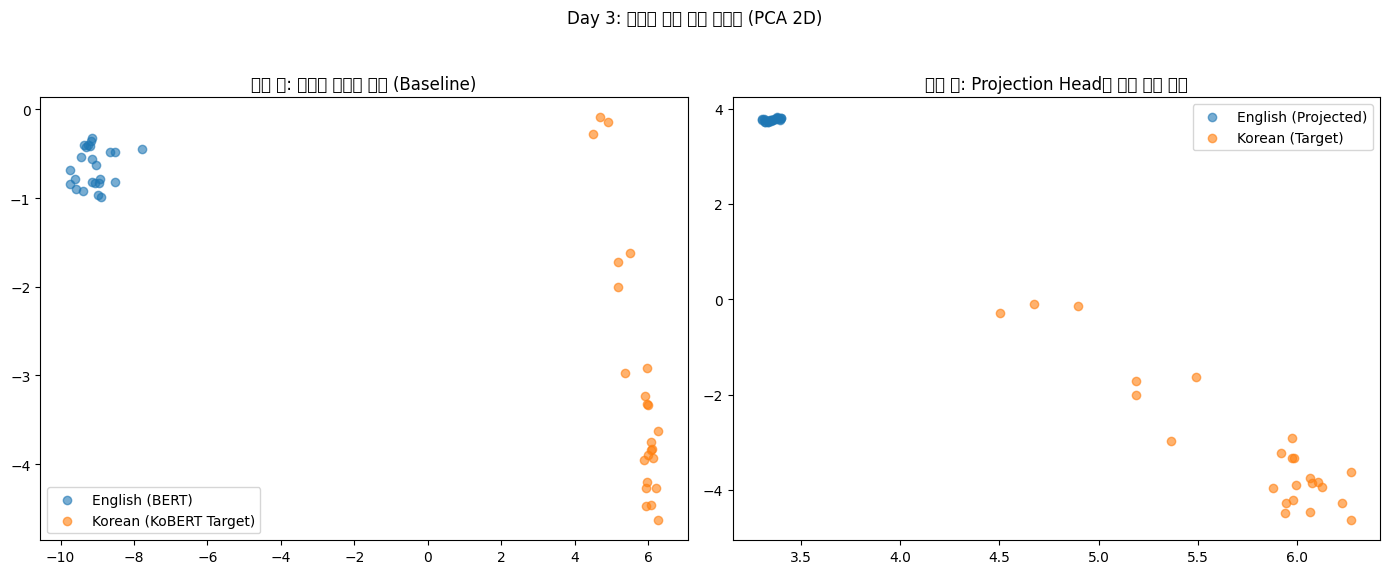

--- Day 3 작업 완료. 미니 프로젝트 보고서 통합 준비 완료 ---


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 768

# --- 1. 정성 분석 (Day 3 오전) ---

def perform_nuance_analysis(eng_sents, kor_sents, baseline_scores, aligned_scores, top_k=5):
    """
    매핑 후 가장 많이 개선되거나 오류가 큰 문장 쌍을 분석
    """
    df = pd.DataFrame({
        'eng': eng_sents,
        'kor': kor_sents,
        'baseline_sim': baseline_scores,
        'aligned_sim': aligned_scores,
        'sim_diff': aligned_scores - baseline_scores
    })
    
    print("\n--- Day 3 오전: 핵심 사례(Case Study) 분석 ---")
    
    # 1. 유사도 개선 상위 사례 (Success Cases)
    top_improved = df.sort_values(by='sim_diff', ascending=False).head(top_k)
    print("🥇 유사도 개선 상위 사례 (Projection Head의 성공):")
    for i, row in top_improved.iterrows():
        print(f"[{row['sim_diff']*100:.2f}% 개선]")
        print(f"  ENG: {row['eng']}")
        print(f"  KOR: {row['kor']}")
        print(f"  Sim. Before: {row['baseline_sim']:.4f} -> After: {row['aligned_sim']:.4f}\n")

    # 2. 잔존 오류 하위 사례 (Limitation Cases)
    bottom_error = df.sort_values(by='aligned_sim', ascending=True).head(top_k)
    print("❌ 잔존 오류 하위 사례 (연구의 한계 명시):")
    for i, row in bottom_error.iterrows():
        print(f"[{row['aligned_sim']:.4f} 최종 유사도]")
        print(f"  ENG: {row['eng']}")
        print(f"  KOR: {row['kor']}")
        print(f"  *분석: (면접 대비) 이 쌍이 정렬에 실패한 이유 (정렬 오류, 뉘앙스 차이 등)를 제시해야 합니다.\n")

# --- 2. 시각화 (Day 3 오후) ---

def visualize_embeddings(eng_embs, kor_embs, projected_eng_embs):
    """
    PCA를 사용하여 매핑 전/후 임베딩 공간 변화 시각화
    """
    # 폰트 설정 (Mac/Linux 환경에 맞게 폰트명 변경 필요)
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        pass

    all_data = np.vstack([eng_embs, kor_embs, projected_eng_embs])
    
    # PCA 학습 및 투영
    pca = PCA(n_components=2)
    pca.fit(all_data)
    
    eng_pca = pca.transform(eng_embs)
    kor_pca = pca.transform(kor_embs)
    proj_eng_pca = pca.transform(projected_eng_embs)
    
    # 시각화 
    plt.figure(figsize=(14, 6))

    # A. 매핑 전 (Baseline)
    plt.subplot(1, 2, 1)
    plt.scatter(eng_pca[:, 0], eng_pca[:, 1], alpha=0.6, label='English (BERT)')
    plt.scatter(kor_pca[:, 0], kor_pca[:, 1], alpha=0.6, label='Korean (KoBERT Target)')
    plt.title('매핑 전: 독립적 임베딩 공간 (Baseline)')
    plt.legend()

    # B. 매핑 후 (Aligned)
    plt.subplot(1, 2, 2)
    plt.scatter(proj_eng_pca[:, 0], proj_eng_pca[:, 1], alpha=0.6, label='English (Projected)')
    plt.scatter(kor_pca[:, 0], kor_pca[:, 1], alpha=0.6, label='Korean (Target)')
    plt.title('매핑 후: Projection Head를 통한 공간 정렬')
    plt.legend()
    
    plt.suptitle("Day 3: 임베딩 공간 정렬 시각화 (PCA 2D)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 3. 메인 실행 ---

if __name__ == "__main__":
    print("--- Day 3: 분석 및 시각화 시작 ---")
    
    # 1. Day 2 학습 결과 로드
    try:
        results = np.load(INPUT_FILE, allow_pickle=True)
        test_eng_embs = results['test_eng_embs']
        test_kor_embs = results['test_kor_embs']
        projected_eng_embs = results['projected_eng_embs']
        baseline_scores = results['baseline_scores']
        aligned_scores = results['aligned_scores']
        eng_sents = results['test_eng_sents']
        kor_sents = results['test_kor_sents']
    except FileNotFoundError:
        print(f"오류: {INPUT_FILE} 파일을 찾을 수 없습니다. Day 2 작업을 먼저 실행하십시오.")
        exit()

    # 2. 정성 분석 실행 (오전)
    perform_nuance_analysis(eng_sents, kor_sents, baseline_scores, aligned_scores, top_k=5)
    
    # 3. 시각화 실행 (오후)
    visualize_embeddings(test_eng_embs, test_kor_embs, projected_eng_embs)
    
    print("--- Day 3 작업 완료. 미니 프로젝트 보고서 통합 준비 완료 ---")

In [15]:
import torch
import torch.nn as nn
from kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer
from tqdm import tqdm
import numpy as np
import os

# -----------------------------
# 1. 모델 구조 정의
# -----------------------------
class KoSentenceBERT(nn.Module):
    def __init__(self, model, vocab):
        super(KoSentenceBERT, self).__init__()
        self.kobert = model
        self.vocab = vocab

    def forward(self, input_ids, attention_mask, token_type_ids):
        sequence_output, pooled_output = self.kobert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # Mean Pooling
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(sequence_output.size()).float()
        sum_embeddings = torch.sum(sequence_output * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask


# -----------------------------
# 2. KoSentenceBERT 로드 함수
# -----------------------------
def load_kosentbert(model_dir="./KoSentenceBERT-SKT", device="cpu"):

    # 2-1. KoBERT 모델 로드
    kobert_model, vocab = get_pytorch_kobert_model()

    # 2-2. SentencePiece 토크나이저 로드
    sp_path = os.path.join(model_dir, "tokenizer_78b3253a26.model")
    tokenizer = SentencepieceTokenizer(sp_path)

    # 2-3. KSBERT 구조 생성
    model = KoSentenceBERT(kobert_model, vocab)
    model.to(device)

    # 2-4. 학습된 KoSentenceBERT-SKT 가중치 로드
    ckpt_path = os.path.join(model_dir, "KSBERT_SKT_NLI_STS.pth")
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

    print("✔ KoSentenceBERT-SKT loaded successfully!")
    return model, tokenizer, vocab


# -----------------------------
# 3. 문장 → 임베딩
# -----------------------------
def get_embeddings(model, tokenizer, vocab, sentences, device="cpu"):

    embeddings = []

    for sent in tqdm(sentences, desc="Encoding"):
        # 토큰화
        tokens = tokenizer(sent)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]

        # ID 변환
        input_ids = torch.tensor([vocab[t] for t in tokens]).unsqueeze(0).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)
        token_type_ids = torch.zeros_like(input_ids).to(device)

        # 임베딩 추출
        with torch.no_grad():
            emb = model(input_ids, attention_mask, token_type_ids)
            embeddings.append(emb.cpu().numpy()[0])

    return np.array(embeddings)


# -----------------------------
# 4. 테스트 실행
# -----------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model, tokenizer, vocab = load_kosentbert("./KoSentenceBERT-SKT", device)

    test_sentences = [
        "오늘 날씨가 참 좋네요.",
        "밥을 먹고 산책을 했습니다."
    ]

    embs = get_embeddings(model, tokenizer, vocab, test_sentences, device)
    print("\nFinal Embeddings Shape:", embs.shape)
    print(embs)


ModuleNotFoundError: No module named 'kobert'